### Import libraries

In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from scipy.stats import ttest_ind
from scipy.stats import chi2_contingency
from scipy.stats import zscore

sns.set_style("darkgrid", {"axes.facecolor": ".9"})

In [2]:
def axes_plot_numerical(data, col_names, nrows, ncols):
    fig, axes = plt.subplots(nrows, ncols, figsize=(12, 8), tight_layout=True)
    for col, ax in zip(col_names, axes.flatten()):
        sns.histplot(data[col], stat='probability', color='red', kde=True, ax=ax)
        ax.set(xlabel=None)
        ax.set_title(col.upper())
        
    if len(col_names) != nrows*ncols:
        restante = nrows*ncols - len(col_names)
        for l in axes.flatten()[-restante:]:
            l.axis('off')
            
def axes_plot_categorical(data, col_names, nrows, ncols):
    fig, axes = plt.subplots(2, 3, figsize=(16, 8), tight_layout=True)
    for col, ax in zip(categorical_columns, axes.flatten()):
        group = data[col].value_counts(normalize=True)
        sns.barplot(y=group.index, x=group, palette='Reds', ax=ax)
        ax.set(xlabel=None)
        ax.set_title(col.upper())
        
    if len(col_names) != nrows*ncols:
        restante = nrows*ncols - len(col_names)
        for l in axes.flatten()[-restante:]:
            l.axis('off')

def f_interquartile_range(values):
    Q1 = values.quantile(0.25)
    Q3 = values.quantile(0.75)
    IQR = Q3 - Q1
    upper_limit = Q3 + 1.5*IQR
    lower_limit = Q1 - 1.5*IQR
    return (lower_limit, upper_limit)

def f_z_score(values):
    return np.abs(zscore(values))

def f_boundaries_z_score(values, threshold):
    upper_boundary = values.mean() + threshold * values.std()
    lower_boundary = values.mean() - threshold * values.std()
    return lower_boundary, upper_boundary

### Import data
Data: https://www.kaggle.com/datasets/sakshigoyal7/credit-card-customers

In [3]:
data = pd.read_csv('BankChurners.csv')

### Data info

In [4]:
data.head(3)

,CLIENTNUM,Attrition_Flag,Customer_Age,Gender,Dependent_count,Education_Level,Marital_Status,Income_Category,Card_Category,Months_on_book,...,Credit_Limit,Total_Revolving_Bal,Avg_Open_To_Buy,Total_Amt_Chng_Q4_Q1,Total_Trans_Amt,Total_Trans_Ct,Total_Ct_Chng_Q4_Q1,Avg_Utilization_Ratio,Naive_Bayes_Classifier_Attrition_Flag_Card_Category_Contacts_Count_12_mon_Dependent_count_Education_Level_Months_Inactive_12_mon_1,Naive_Bayes_Classifier_Attrition_Flag_Card_Category_Contacts_Count_12_mon_Dependent_count_Education_Level_Months_Inactive_12_mon_2
0,768805383,Existing Customer,45,M,3,High School,Married,$60K - $80K,Blue,39,...,12691.0,777,11914.0,1.335,1144,42,1.625,0.061,0.000093,0.99991
1,818770008,Existing Customer,49,F,5,Graduate,Single,Less than $40K,Blue,44,...,8256.0,864,7392.0,1.541,1291,33,3.714,0.105,0.000057,0.99994
2,713982108,Existing Customer,51,M,3,Graduate,Married,$80K - $120K,Blue,36,...,3418.0,0,3418.0,2.594,1887,20,2.333,0.000,0.000021,0.99998


In [5]:
data.shape

(10127, 23)

In [6]:
# Data type of each column
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10127 entries, 0 to 10126
Data columns (total 23 columns):
 #   Column                                                                                                                              Non-Null Count  Dtype  
---  ------                                                                                                                              --------------  -----  
 0   CLIENTNUM                                                                                                                           10127 non-null  int64  
 1   Attrition_Flag                                                                                                                      10127 non-null  object 
 2   Customer_Age                                                                                                                        10127 non-null  int64  
 3   Gender                                                                           

We don't have missing values

In [7]:
# Column names
data.columns

Index(['CLIENTNUM', 'Attrition_Flag', 'Customer_Age', 'Gender',
       'Dependent_count', 'Education_Level', 'Marital_Status',
       'Income_Category', 'Card_Category', 'Months_on_book',
       'Total_Relationship_Count', 'Months_Inactive_12_mon',
       'Contacts_Count_12_mon', 'Credit_Limit', 'Total_Revolving_Bal',
       'Avg_Open_To_Buy', 'Total_Amt_Chng_Q4_Q1', 'Total_Trans_Amt',
       'Total_Trans_Ct', 'Total_Ct_Chng_Q4_Q1', 'Avg_Utilization_Ratio',
       'Naive_Bayes_Classifier_Attrition_Flag_Card_Category_Contacts_Count_12_mon_Dependent_count_Education_Level_Months_Inactive_12_mon_1',
       'Naive_Bayes_Classifier_Attrition_Flag_Card_Category_Contacts_Count_12_mon_Dependent_count_Education_Level_Months_Inactive_12_mon_2'],
      dtype='object')

# EDA

### Remove unnecessary columns

In [8]:
unn_columns = [
    'CLIENTNUM', 
    'Naive_Bayes_Classifier_Attrition_Flag_Card_Category_Contacts_Count_12_mon_Dependent_count_Education_Level_Months_Inactive_12_mon_1',
    'Naive_Bayes_Classifier_Attrition_Flag_Card_Category_Contacts_Count_12_mon_Dependent_count_Education_Level_Months_Inactive_12_mon_2'
]
data.drop(unn_columns, axis=1, inplace=True)
print('Total unnecessary columns: %d' %len(unn_columns))

Total unnecessary columns: 3


### Extract Numerical Columns and Distributions

In [9]:
numerical_columns = list(data.dtypes[(data.dtypes == 'int64') | (data.dtypes == 'float64')].index)
print('Total numerical columns: %d' %len(numerical_columns))

Total numerical columns: 14


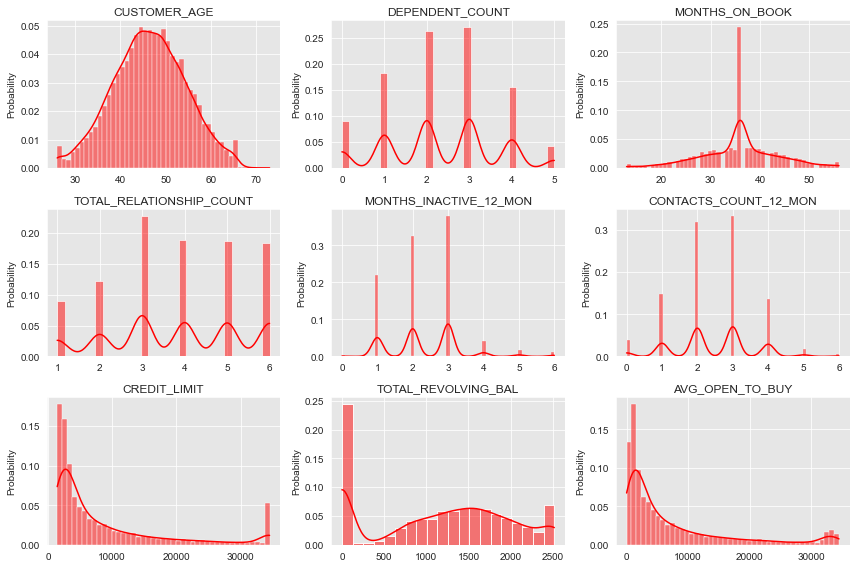

In [10]:
axes_plot_numerical(data, numerical_columns[:9], 3, 3)

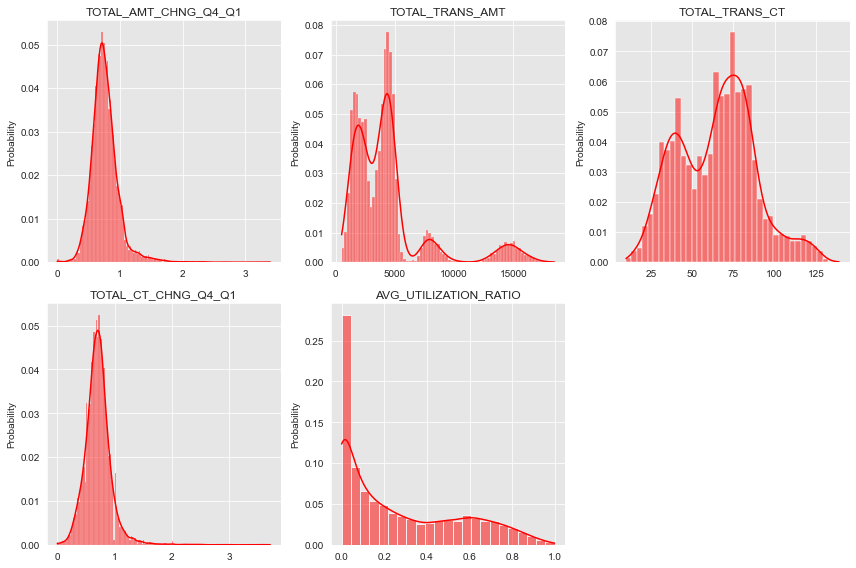

In [11]:
axes_plot_numerical(data, numerical_columns[9:], 2, 3)

### Correlation Analysis

Correlation Analysis for numerical variables<br>
Is interesting to see a couple of highly correlated variables

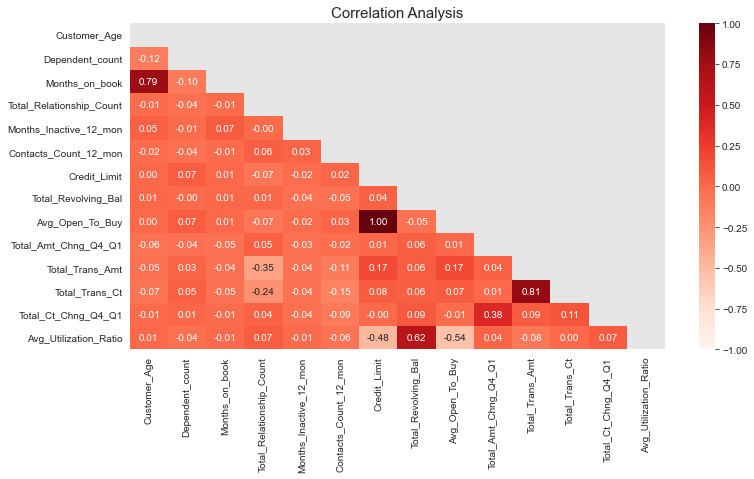

In [12]:
corr = data[numerical_columns].corr()
matrix = np.triu(corr)

plt.figure(figsize=(12, 6))
plt.title("Correlation Analysis", size=15)
sns.heatmap(corr, cmap='Reds', vmin=-1, 
            vmax=1, annot=True, mask=matrix, fmt=".2f");

### Extract Categorical Columns and Barplots

In [13]:
categorical_columns = list(data.dtypes[(data.dtypes == 'O')].index)
print('Total categorical columns: %d' %len(categorical_columns))

Total categorical columns: 6


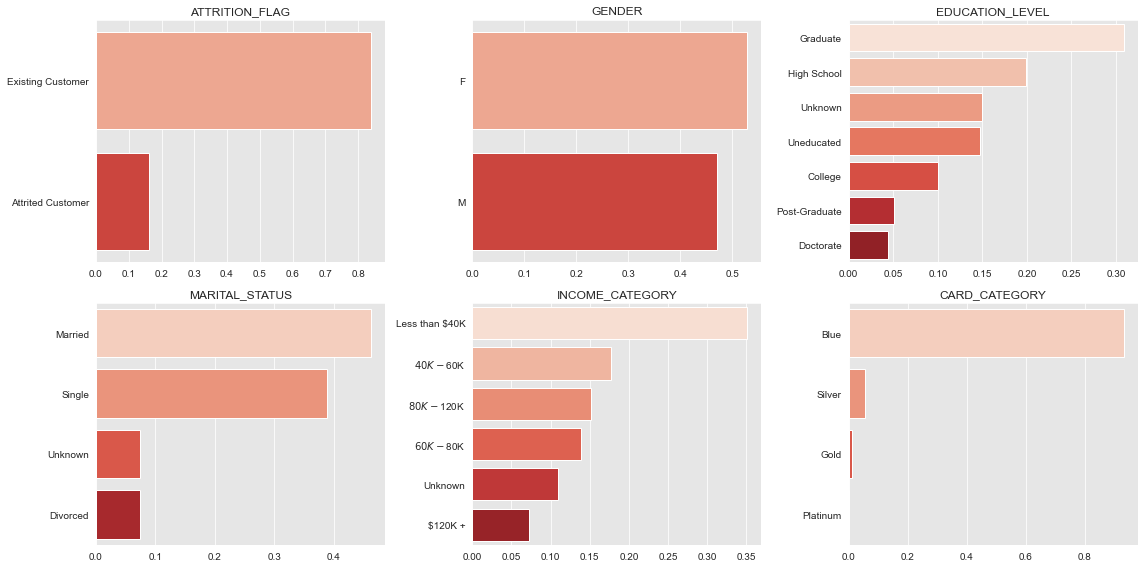

In [14]:
axes_plot_categorical(data, categorical_columns, 2, 3)

As can be seen in the __Card Category__ variable, the most common category is Blue. Ninety-three percent of customers have a Blue card, while less than 0.20% have a Platinum card.

In [15]:
data["Card_Category"].value_counts(normalize=True)*100

Blue        93.176656
Silver       5.480399
Gold         1.145453
Platinum     0.197492
Name: Card_Category, dtype: float64

### Bivariate Analysis

Questions of interest:<br>

1. How the age behaves based on the churn?
2. Which gender is less comfortable with the Bank?
3. Is there any relationship between "Total Transaction Amount" and "Total Transaction Count"?
4. Is there any relationship between "Education Level" and "Marital Status"?

#### How the age behaves based on the churn?

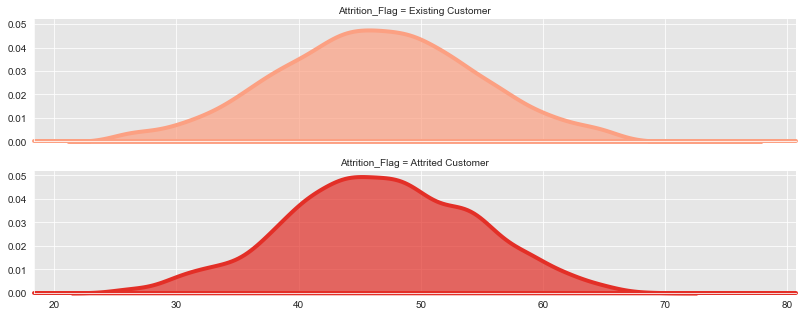

In [16]:
ridge = sns.FacetGrid(data, row="Attrition_Flag", hue="Attrition_Flag", aspect=5, height=2.25, palette='Reds')
ridge.map(sns.kdeplot, "Customer_Age", clip_on=False, shade=True, alpha=0.7, lw=4, bw_method=.2)
ridge.map(plt.axhline, y=0, lw=4, clip_on=False);

In [17]:
data.groupby('Attrition_Flag').mean()[['Customer_Age']]

,Customer_Age
Attrition_Flag,
Attrited Customer,46.659496
Existing Customer,46.262118


To be more precise we can use two sample t-test to test whether the mean between the two groups is really different or not.

#### Which gender is less comfortable with the Bank?

In [18]:
(data['Gender'].value_counts(normalize=True)*100).round()

F    53.0
M    47.0
Name: Gender, dtype: float64

In [19]:
attrited_cus_gender = data[data['Attrition_Flag'] == 'Attrited Customer']
group = (attrited_cus_gender['Gender'].value_counts(normalize=True)*100).round().rename('Percent').reset_index()

In [20]:
group

,index,Percent
0,F,57.0
1,M,43.0


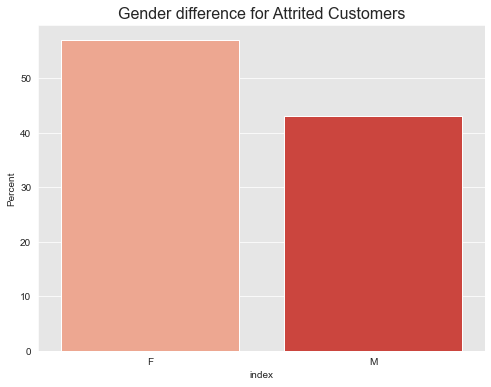

In [21]:
plt.figure(figsize=(8, 6))
sns.barplot(data=group, x='index', y='Percent', palette='Reds')
plt.title('Gender difference for Attrited Customers', size=16);

With this plot I was curious if the Attrition and the Gender were __INDEPENDENT__. <br>
To prove that, I'll use contingency tables and the __Chi Square Test__

Contingency tables are a really useful tool, especially if we work with categorical data. The whole idea is to compare the __observed data__ with the __expected data__ and using the Chi-Square distribution we check whether the difference between this two is normal or not. This is just a very casual explanation. I attach a video that explains it all very well.

https://www.youtube.com/watch?v=misMgRRV3jQ

In [22]:
d1 = pd.pivot_table(data=data, values='Education_Level', index='Gender', columns='Attrition_Flag', aggfunc='count', margins=True)
d2 = pd.pivot_table(data=data, values='Education_Level', index='Gender', columns='Attrition_Flag', aggfunc='count')
d1

Attrition_Flag,Attrited Customer,Existing Customer,All
Gender,,,
F,930,4428,5358
M,697,4072,4769
All,1627,8500,10127


In [23]:
chi2, p_value, dof, expected = chi2_contingency(d2)

$H0 =$ __Attrition__ and __Gender__ are independent <br>
$H1 =$ __Attrition__ and __Gender__ are dependent

In [24]:
if p_value < 0.05:
    print('Reject null hypothesis')
else:
    print('Accept null hypothesis')

Reject null hypothesis


The results are interesting. The plot that shows the percentage between Male and Female for the Attrited Customers was weird. I was expecting to have almost the same percentage of male and females for Attrited Customer and Existing Customer. Why is that? Well, I have seen this behavior in other scenarios. Is not a rule.

In this case is interesting that more females tend to leave. Yes, we do have more females than males, but it was a red flag to see how much more females we have for Attrited Customers.

#### Is there any relationship between "Total Transaction Amount" and "Total Transaction Count"?

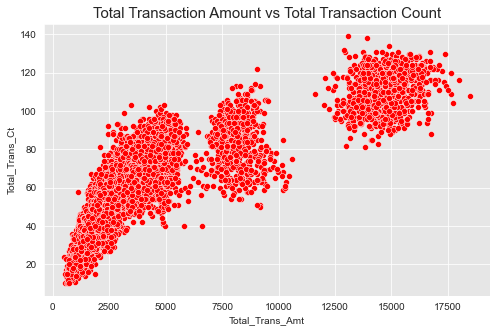

In [25]:
plt.figure(figsize=(8, 5))
sns.scatterplot(x=data["Total_Trans_Amt"], y=data["Total_Trans_Ct"], color='red')
plt.title("Total Transaction Amount vs Total Transaction Count", size=15);

In [26]:
# Pearson Correlation
data[['Total_Trans_Amt', 'Total_Trans_Ct']].corr()

,Total_Trans_Amt,Total_Trans_Ct
Total_Trans_Amt,1.000000,0.807192
Total_Trans_Ct,0.807192,1.000000


The results are amazing. In the graph we can clearly see three groups. They could be three different types of customers. We also have a high correlation, almost 0.81.

#### Is there any relationship between "Education Level" and "Marital Status"?

In [27]:
# I will not contemplate "Unknown" labels for both columns
data_n_unknown = data[(data['Education_Level'] != 'Unknown') & (data['Income_Category'] != 'Unknown')]
d1 = pd.pivot_table(data=data_n_unknown, values='Gender', index='Education_Level', columns='Income_Category', aggfunc='count', margins=True)
d2 = pd.pivot_table(data=data_n_unknown, values='Gender', index='Education_Level', columns='Income_Category', aggfunc='count')
d1

Income_Category,$120K +,$40K - $60K,$60K - $80K,$80K - $120K,Less than $40K,All
Education_Level,,,,,,
College,70,183,132,175,345,905
Doctorate,37,70,59,57,158,381
Graduate,204,553,422,478,1139,2796
High School,147,355,307,308,671,1788
Post-Graduate,30,111,77,81,170,469
Uneducated,119,249,195,217,522,1302
All,607,1521,1192,1316,3005,7641


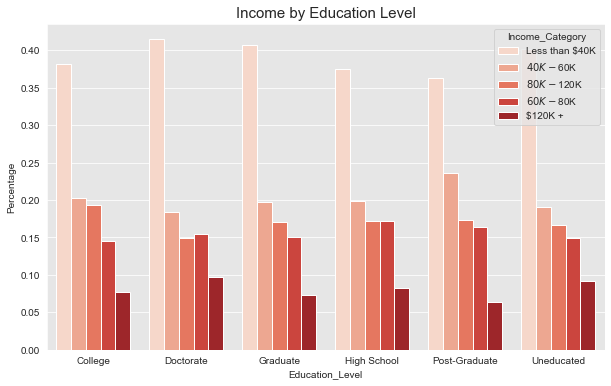

In [28]:
group = data_n_unknown.groupby(['Education_Level'])['Income_Category'].value_counts(normalize=True).rename('Percentage').reset_index()
plt.figure(figsize=(10, 6))
sns.barplot(data=group, x='Education_Level', y='Percentage', hue='Income_Category', palette='Reds');
plt.title('Income by Education Level', size=15);

In [29]:
chi2, p_value, dof, expected = chi2_contingency(d2)

In [30]:
if p_value < 0.05:
    print('Reject null hypothesis')
else:
    print('Accept null hypothesis')

Accept null hypothesis


This is the other result we can expect when performing Chi Square Test. For this question we conclude that there is no statistical dependence between the two variables.

### Outlier Analysis

There are a couple of variables that I would like to analyze for the existence of outliers.

In [31]:
# Variables:
# 1. Credit_Limit
# 2. Total_Amt_Chng_Q4_Q1
# 3. Total_Ct_Chng_Q4_Q1

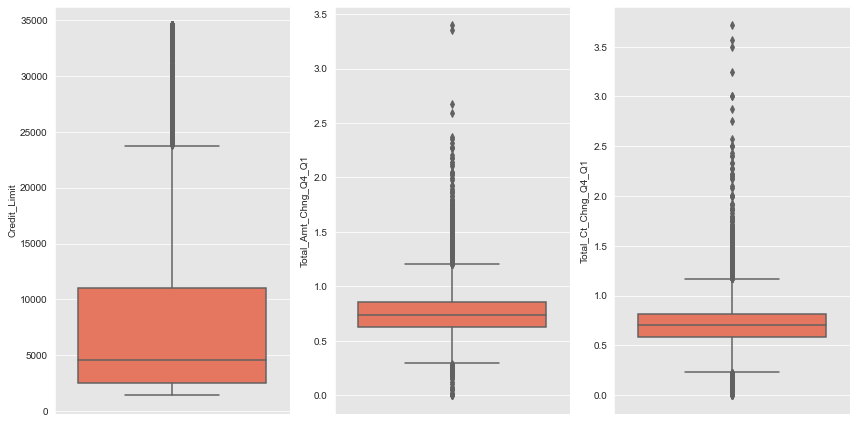

In [32]:
fig, axes = plt.subplots(1, 3, figsize=(12, 6), tight_layout=True)
sns.boxplot(y=data["Credit_Limit"], ax=axes[0], palette='Reds')
sns.boxplot(y=data["Total_Amt_Chng_Q4_Q1"], ax=axes[1], palette='Reds')
sns.boxplot(y=data["Total_Ct_Chng_Q4_Q1"], ax=axes[2], palette='Reds');

For these three variables, how many data points are outside the interquartile range?

In [33]:
# Credit Limit
ll_CL, up_CL = f_interquartile_range(data["Credit_Limit"])
num_rows = data[
    (data["Credit_Limit"] < ll_CL) | 
    (data["Credit_Limit"] > up_CL)].shape[0]
print(f"Total number of rows out of the interquartile range: {num_rows}")

Total number of rows out of the interquartile range: 984


In [34]:
# Total_Amt_Chng_Q4_Q1
ll_TAC, up_TAC = f_interquartile_range(data["Total_Amt_Chng_Q4_Q1"])
num_rows = data[
    (data["Total_Amt_Chng_Q4_Q1"] < ll_TAC) | 
    (data["Total_Amt_Chng_Q4_Q1"] > up_TAC)].shape[0]
print(f"Total number of rows out of the interquartile range: {num_rows}")

Total number of rows out of the interquartile range: 396


In [35]:
# Total_Ct_Chng_Q4_Q1
ll_TCC, up_TCC = f_interquartile_range(data["Total_Ct_Chng_Q4_Q1"])
num_rows = data[
    (data["Total_Ct_Chng_Q4_Q1"] < ll_TCC) | 
    (data["Total_Ct_Chng_Q4_Q1"] > up_TCC)].shape[0]
print(f"Total number of rows out of the interquartile range: {num_rows}")

Total number of rows out of the interquartile range: 394


I will also use zscore to extract a different perspective on outliers.

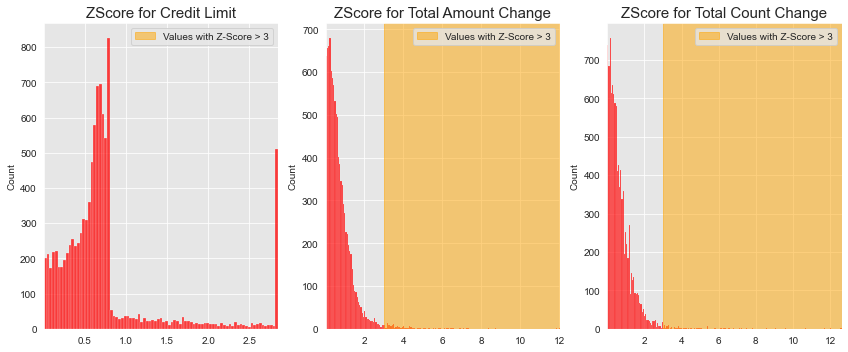

In [36]:
CL_ZS = f_z_score(data["Credit_Limit"])
TAC_ZS = f_z_score(data["Total_Amt_Chng_Q4_Q1"])
TCC_ZS = f_z_score(data["Total_Ct_Chng_Q4_Q1"])
fig, axes = plt.subplots(1, 3, figsize=(12, 5), tight_layout=True)

sns.histplot(CL_ZS, color='red', ax=axes[0])
sns.histplot(TAC_ZS, color='red', ax=axes[1])
sns.histplot(TCC_ZS, color='red', ax=axes[2])

axes[0].axvspan(3, axes[0].get_xlim()[1], color='orange', alpha=0.5, label='Values with Z-Score > 3')
axes[1].axvspan(3, axes[1].get_xlim()[1], color='orange', alpha=0.5, label='Values with Z-Score > 3')
axes[2].axvspan(3, axes[2].get_xlim()[1], color='orange', alpha=0.5, label='Values with Z-Score > 3')

axes[0].set_xlim([CL_ZS.min(), CL_ZS.max()])
axes[1].set_xlim([TAC_ZS.min(), TAC_ZS.max()])
axes[2].set_xlim([TCC_ZS.min(), TCC_ZS.max()])

axes[0].set_title("ZScore for Credit Limit", size=15)
axes[1].set_title("ZScore for Total Amount Change", size=15)
axes[2].set_title("ZScore for Total Count Change", size=15)

axes[0].legend()
axes[1].legend()
axes[2].legend();

There are different thresholds that we can use to discriminate outliers using the zscore. I decided to use 3 as the threshold.<br>
The results are interesting. While using the IQR we have almost 1,000 rows identified as outliers for the __Credit Limit__ variable, with the zscore we identify 0 outliers.<br>

In [37]:
print("Outliers identify for {}: {}".format('Credit Limit', len(np.where(CL_ZS > 3)[0])))
print("Outliers identify for {}: {}".format('Total Amount Change', len(np.where(TAC_ZS > 3)[0])))
print("Outliers identify for {}: {}".format('Total Count Change', len(np.where(TCC_ZS > 3)[0])))

Outliers identify for Credit Limit: 0
Outliers identify for Total Amount Change: 163
Outliers identify for Total Count Change: 113


Let's apply capping to the data <br>
The idea is not to modify the data in this notebook, just to analyze the results

In [38]:
lower_boundary_CL, upper_boundary_CL = f_boundaries_z_score(data["Credit_Limit"], 3)
credit_limit_capping = np.where(
                                data["Credit_Limit"] > upper_boundary_CL, 
                                upper_boundary_CL, 
                                np.where(
                                        data["Credit_Limit"] < lower_boundary_CL,
                                        lower_boundary_CL,
                                        data["Credit_Limit"]))

lower_boundary_TAC, upper_boundary_TAC = f_boundaries_z_score(data["Total_Amt_Chng_Q4_Q1"], 3)
total_amount_change_capping = np.where(
                                data["Total_Amt_Chng_Q4_Q1"] > upper_boundary_TAC, 
                                upper_boundary_TAC, 
                                np.where(
                                        data["Total_Amt_Chng_Q4_Q1"] < lower_boundary_TAC,
                                        lower_boundary_TAC,
                                        data["Total_Amt_Chng_Q4_Q1"]))

lower_boundary_TCC, upper_boundary_TCC = f_boundaries_z_score(data["Total_Ct_Chng_Q4_Q1"], 3)
total_count_change_capping = np.where(
                                data["Total_Ct_Chng_Q4_Q1"] > upper_boundary_TCC, 
                                upper_boundary_TCC, 
                                np.where(
                                        data["Total_Ct_Chng_Q4_Q1"] < lower_boundary_TCC,
                                        lower_boundary_TCC,
                                        data["Total_Ct_Chng_Q4_Q1"]))

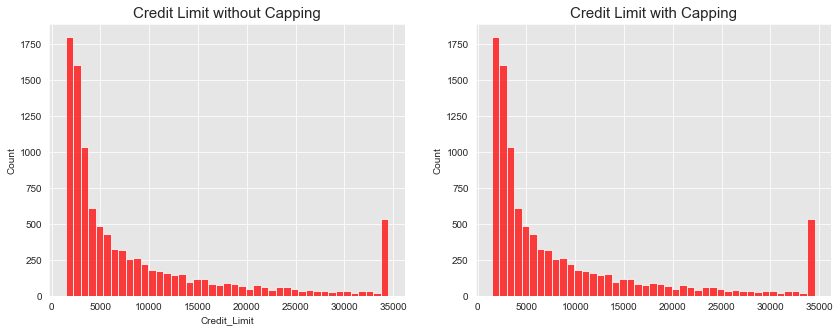

In [39]:
fig, axes = plt.subplots(1, 2, figsize=(14, 5))
sns.histplot(data["Credit_Limit"], color='Red', ax=axes[0])
sns.histplot(credit_limit_capping, color='Red', ax=axes[1])

axes[0].set_title("Credit Limit without Capping", size=15)
axes[1].set_title("Credit Limit with Capping", size=15);

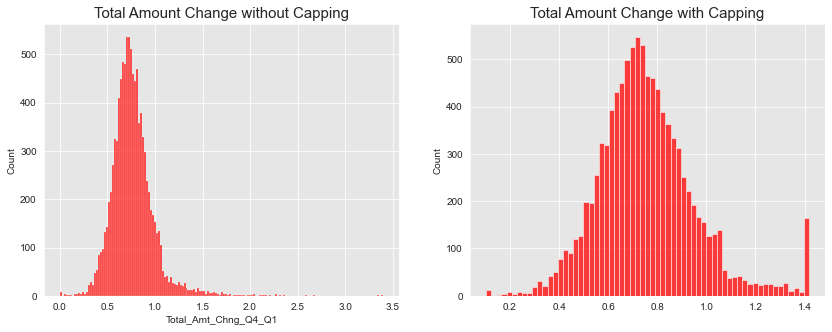

In [40]:
fig, axes = plt.subplots(1, 2, figsize=(14, 5))
sns.histplot(data["Total_Amt_Chng_Q4_Q1"], color='Red', ax=axes[0])
sns.histplot(total_amount_change_capping, color='Red', ax=axes[1])

axes[0].set_title("Total Amount Change without Capping", size=15)
axes[1].set_title("Total Amount Change with Capping", size=15);

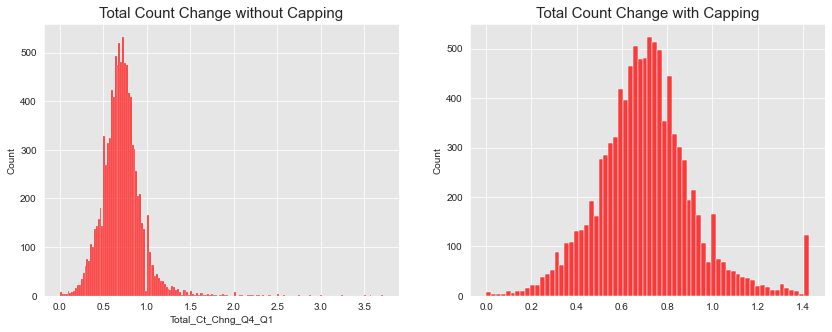

In [41]:
fig, axes = plt.subplots(1, 2, figsize=(14, 5))
sns.histplot(data["Total_Ct_Chng_Q4_Q1"], color='Red', ax=axes[0])
sns.histplot(total_count_change_capping, color='Red', ax=axes[1])

axes[0].set_title("Total Count Change without Capping", size=15)
axes[1].set_title("Total Count Change with Capping", size=15);